# An example using Feature weighted ECM clustering


In [13]:
## Importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.fwecm import fwecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import datasets as skdatasets


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Breast cancer DS: 569 instances, 30 features


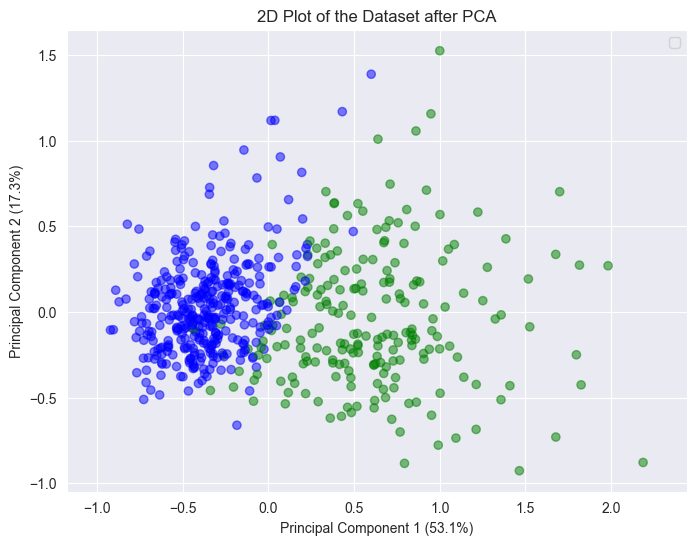

In [14]:
# fetch dataset
breast_cancer = skdatasets.load_breast_cancer()

scaler = MinMaxScaler(feature_range=(0, 1))
breast_data = scaler.fit_transform(breast_cancer.data)
# data (as pandas dataframes)
X = pd.DataFrame(breast_data, columns=breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns=['class'])

labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y['class'])
df = pd.concat([X, y], axis=1)

# Scatter matrix plot
# sns.pairplot(df, corner=True, hue="class")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions
data_reduced = pca.fit_transform(X)
variance_percent = np.round(pca.explained_variance_ratio_ * 100, 1)

print(f"Breast cancer DS: {X.shape[0]} instances, {X.shape[1]} features")
# Plot the reduced dataset with different colors for each cluster
value_to_color = {0: 'green', 1: 'blue', 2: 'red'}
colors = [value_to_color[val] for val in numeric_labels]

plt.figure(figsize=(8, 6))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], alpha=0.5, c=colors)
plt.title('2D Plot of the Dataset after PCA')
plt.xlabel(f"Principal Component 1 ({variance_percent[0]}%)")
plt.ylabel(f"Principal Component 2 ({variance_percent[1]}%)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Normalization
scaler = MinMaxScaler((0,1))
X = pd.DataFrame(scaler.fit_transform(X))

In [15]:
# Non-specificity values
def calculate_non_specificity(cluster_model):
    m = cluster_model['mass']
    F = cluster_model['F']
    c = F.shape[1]
    card = np.sum(F[1:F.shape[0], :], axis=1)

    log_card = np.log2(card)
    tmp = np.tile(log_card.transpose(), (m.shape[0], 1))
    m_log_card = m[:, :-1] * tmp

    mvide = m[:, -1][:, np.newaxis]
    tmp2 = mvide * np.log2(c)
    tmp3 = np.tile(tmp2, (1, m.shape[1] - 1))

    non_specificity = m_log_card + tmp3
    object_non_specificity = np.sum(non_specificity, axis=1)

    print(f"Maximum Non-specificity value: {max(object_non_specificity)}")
    print(f"Minimum Non-specificity value: {min(object_non_specificity)}")
    print(f"Average Non-specificity value: {np.mean(object_non_specificity)}")
    # Plot the values
    # plt.clf()
    # plt.hist(object_non_specificity, bins=30, density=True, alpha=0.7, color='blue')
    # plt.xlabel('Value')
    # plt.ylabel('Density')
    # plt.title('Non-specificity Value Distribution Plot')
    # plt.grid(True)
    # plt.show()

## Traditional ECM

[1, 126.577293873618]
[2, 126.24279502436306]
[3, 126.20716108673967]
[4, 126.20038832213075]
[5, 126.19883380626128]
[6, 126.19845041832872]
[  0.         126.19845042 126.19845042]
[1, 126.603534786162]
[2, 126.24755269337726]
[3, 126.20824917567413]
[4, 126.20065814401677]
[5, 126.19890251782834]
[6, 126.19846811409248]
[  1.         126.19846811 126.19845042]
[1, 126.57729387361799]
[2, 126.24279502436306]
[3, 126.20716108673966]
[4, 126.20038832213076]
[5, 126.19883380626128]
[6, 126.1984504183287]
[  2.         126.19845042 126.19845042]
[1, 126.577293873618]
[2, 126.24279502436306]
[3, 126.20716108673967]
[4, 126.20038832213075]
[5, 126.19883380626128]
[6, 126.19845041832872]
[  3.         126.19845042 126.19845042]
[1, 126.60353478616203]
[2, 126.24755269337726]
[3, 126.20824917567413]
[4, 126.20065814401677]
[5, 126.19890251782833]
[6, 126.19846811409246]
[  4.         126.19846811 126.19845042]
[1, 126.577293873618]
[2, 126.24279502436306]
[3, 126.20716108673967]
[4, 126.2003

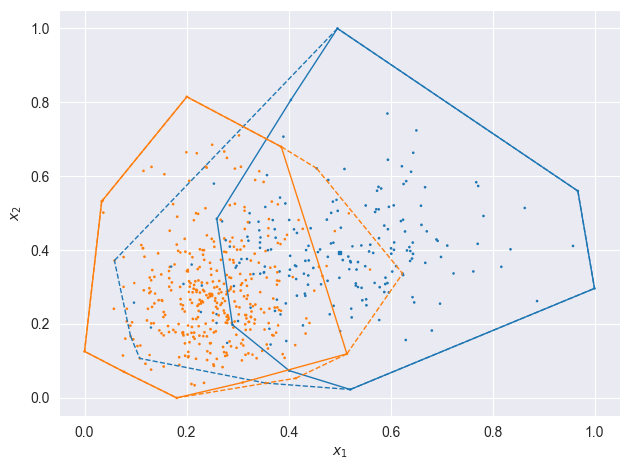

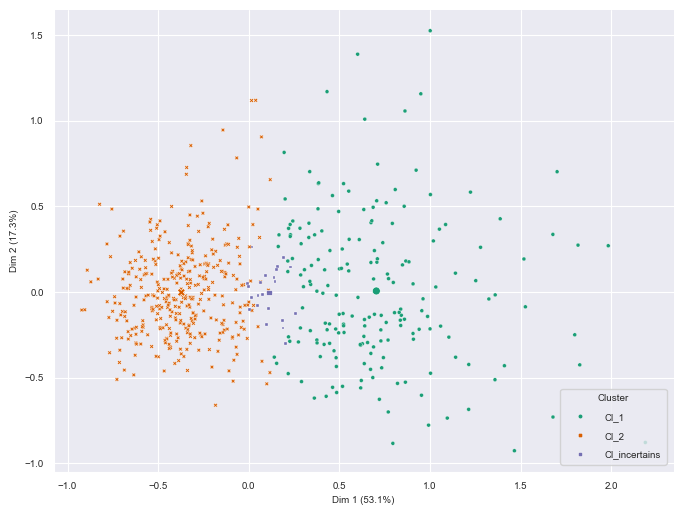

----------Traditional ECM----------
Adjusted Rand Index (ARI): 0.7304861795899276
Maximum Non-specificity value: 1.9322294708693601
Minimum Non-specificity value: 0.33480282331068245
Average Non-specificity value: 1.0906155497823231


In [16]:
# Traditional ECM clustering
model = ecm(x=X, c=2, beta=2, alpha=1, delta=100, ntrials=10)

ev_plot(model, X=X)
ev_pcaplot(data=X, x=model, normalize=False)

# Compute the Adjusted Rand Index (ARI)
true_labels = numeric_labels
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Traditional ECM----------")
print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Non-specificity
calculate_non_specificity(model)

## Feature weighted ECM (FW-ECM)

In [19]:
# Feature weighted ECM clustering
c = 2
d = X.shape[1]
W = np.ones((c, d)) * (1/d)
model = fwecm(x=X, c=c, W=W, beta=2, alpha=1, delta=100, ntrials=10)

Initial weight matrix: 
 [[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]]
[1, 0.14065428331109947]
[2, 0.12625954193663852]
[0.         0.12625954 0.12625954]
Initial weight matrix: 
 [[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333 

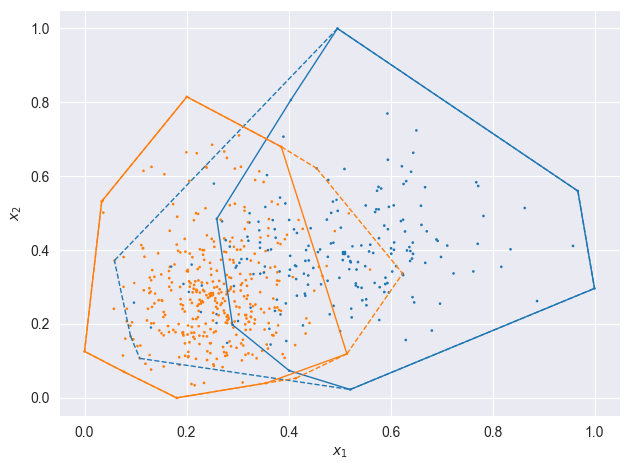

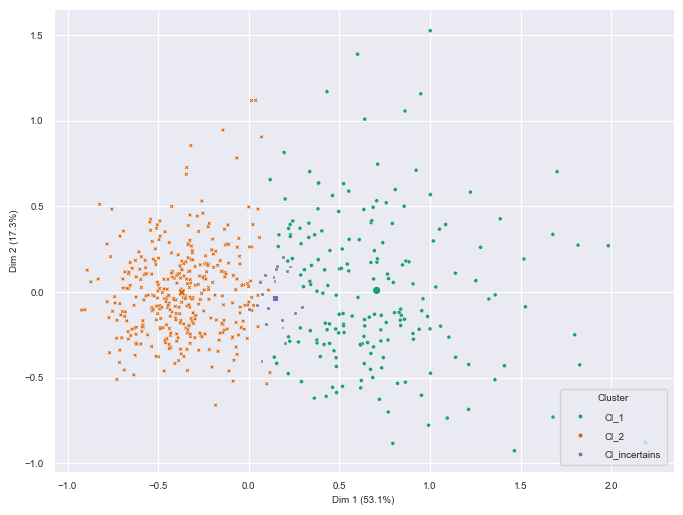

Weight matrix: 
 [[0.02704606 0.03416838 0.02735841 0.02789204 0.03972308 0.02947021
  0.02457964 0.02470494 0.03374622 0.02728234 0.03878122 0.04005593
  0.04018128 0.04193829 0.04414663 0.03307615 0.04822906 0.04045029
  0.03509278 0.04447328 0.02580377 0.02955746 0.02761367 0.02973241
  0.0323002  0.02915245 0.02993512 0.02478752 0.03358734 0.03513381]
 [0.03182999 0.01969308 0.03252752 0.04000534 0.02622765 0.03142113
  0.03196452 0.03208664 0.0242712  0.02312589 0.04864104 0.02388217
  0.05018788 0.05405287 0.03286954 0.03153335 0.04958272 0.03540118
  0.03215774 0.04285036 0.03423    0.01581858 0.03582662 0.04463442
  0.02072539 0.03376998 0.0303534  0.01880119 0.03453452 0.0369941 ]]
Centers: 
 [[0.50796954 0.39320182 0.50818555 0.36527187 0.46453216 0.41555692
  0.40783416 0.46371381 0.45176277 0.29097558 0.18747753 0.19047297
  0.17541514 0.12775883 0.17801267 0.25212382 0.11976687 0.30346506
  0.18117263 0.12790887 0.48127795 0.44454451 0.4658184  0.31454538
  0.48847518 0.35

In [20]:

ev_plot(model, X=X)
ev_pcaplot(data=X, x=model, normalize=False)

true_labels = numeric_labels
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

W = model['W']
print(f"Weight matrix: \n {W}")
print(f"Centers: \n {model['g']}")
# cov_mat1 = np.cov(X[predicted_labels == 0].transpose())
# cov_mat2 = np.cov(X[predicted_labels == 1].transpose())
# print(f"Covariance Matrix 1: {cov_mat1.diagonal()}")
# print(f"Covariance Matrix 2: {cov_mat2.diagonal()}")
# 
# W_COV_1 = pd.DataFrame({'y': W[0, :], 'x': cov_mat1.diagonal()})
# W_COV_1.sort_values('x', inplace=True)
# W_COV_2 = pd.DataFrame({'y': W[1, :], 'x': cov_mat2.diagonal()})
# W_COV_2.sort_values('x', inplace=True)
# 
# plt.clf()
# plt.scatter(W_COV_1['x'], W_COV_1['y'], label = "cluster 1", marker='o')
# plt.scatter(W_COV_2['x'], W_COV_2['y'], label = "cluster 2", marker='o')
# plt.xlabel("Variance of clusters")
# plt.ylabel("Weight of clusters w.r.t each dimension")
# plt.legend()
# plt.show()

# Compute the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Feature weighted ECM----------")
print(f"Adjusted Rand Index (ARI): {ari} - J value: {model['crit']}")

# Calculate Non-specificity
calculate_non_specificity(model)